# TestCase4 - ErrorMap

In [11]:
# sélection du cas test
testcase = 4
version = 7
degree = 1
param_num = 1

torch loaded; device is cpu


**Idée :** On se place ici dans le TestCase3.

On cherche à afficher des cartes d'erreur sur la solution.

## Imports + Load

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns

# from modules.fenics_expressions import UexExpr
from scimba.equations.domain import SpaceTensor
from scimba.equations import domain

from modules.utils import create_tree
from modules.geometry import Donut,Circle
from modules.fenics_expressions import FExpr,UexExpr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
if testcase == 4:
    if version == 1:
        from modules.testcases.d2.test_4.test_4_v1 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4 import FEMSolver
    elif version == 2:
        from modules.testcases.d2.test_4.test_4_v2 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut import FEMSolver
    elif version == 3:
        from modules.testcases.d2.test_4.test_4_v3 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut import FEMSolver
    elif version == 4:
        from modules.testcases.d2.test_4.test_4_v4 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut_v4 import FEMSolver
    elif version == 5:
        from modules.testcases.d2.test_4.test_4_v5 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut_v5 import FEMSolver
    elif version == 7:
        from modules.testcases.d2.test_4.test_4_v7 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut_v4 import FEMSolver
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase4
    problem = TestCase4(v=version)
else:
    raise ValueError("Testcase not found")


dim_params = problem.nb_parameters
result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/errormap/"
create_tree(result_dir)

tab_nb_vert = [20]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

hmax =  0.13314799984383346


2
[[-0.5, 0.500001], [-0.5, 0.500001]]
[[-0.5, 0.500001], [-0.5, 0.500001]]
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_fe4_v7.pth
jsbdbshd
network loaded
Error  tensor([0.0006])


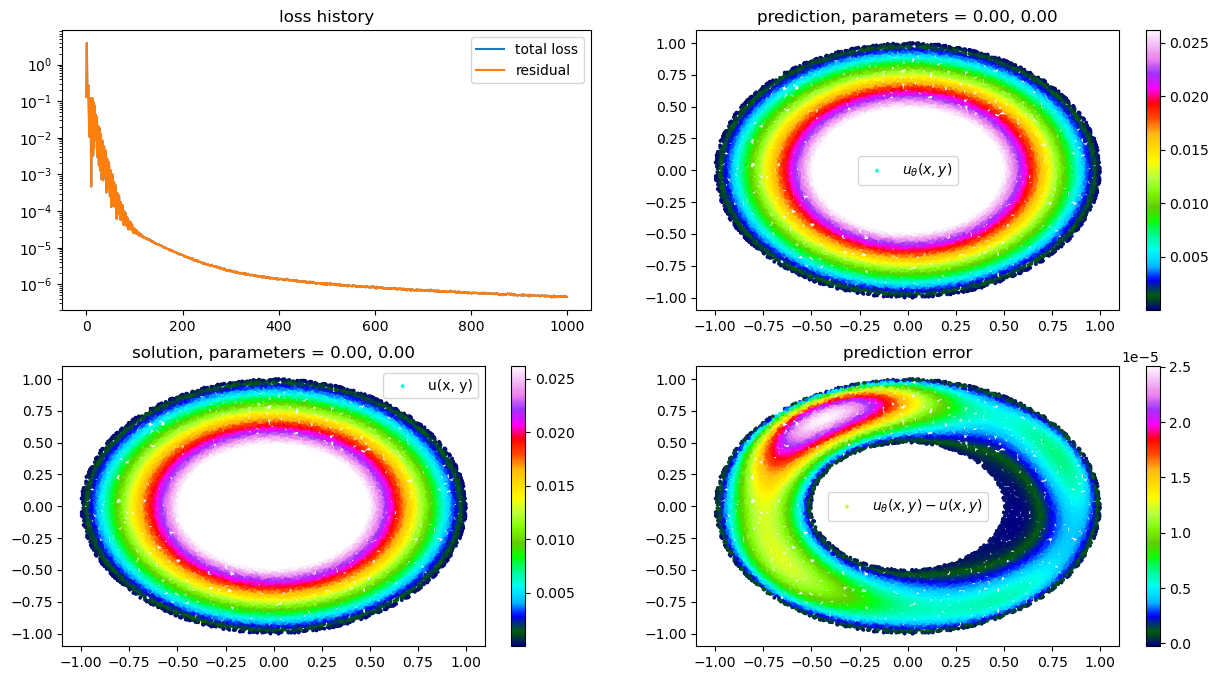

In [15]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [16]:
def get_param(n_params):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    params = []
    for j in range(n_params):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
        param = np.round(param, 2)
        params.append(param)
    return params

n_params = 20
params = get_param(n_params)
params_str = [f"{param}" for param in params]
params_str

['[0.05 0.22]',
 '[0.1  0.04]',
 '[-0.08  0.15]',
 '[-0.06  0.39]',
 '[ 0.46 -0.12]',
 '[0.29 0.03]',
 '[0.07 0.43]',
 '[-0.43 -0.41]',
 '[-0.48  0.33]',
 '[0.28 0.37]',
 '[0.48 0.3 ]',
 '[-0.04  0.28]',
 '[-0.38  0.14]',
 '[-0.36  0.44]',
 '[ 0.02 -0.09]',
 '[-0.24  0.27]',
 '[-0.04  0.07]',
 '[-0.48  0.12]',
 '[0.11 0.12]',
 '[0.44 0.18]']

## Erreurs PINNs

In [17]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [18]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        colormap = "jet"
        tab_err_PINNs = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()

                if version < 4:
                    uref_Vex = df.interpolate(u_ref,solver.V_ex)
                elif version == 4 or version == 5 or version==7:
                    u_ex = UexExpr(params[i], degree=solver.high_degree, domain=solver.mesh, pb_considered=solver.pb_considered)
                    uref_Vex = df.interpolate(u_ex,solver.V_ex)
                else:
                    raise ValueError("Version not found")
                   
                norme_L2 = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))
            
                plt.figure(figsize=(15,5))
                
                plt.subplot(1,3,1)
                c = df.plot(uref_Vex,cmap=colormap)
                plt.colorbar(c)
                plt.title("uref")
                
                plt.subplot(1,3,2)
                c = df.plot(u_PINNs,cmap=colormap)
                plt.colorbar(c)
                plt.title("uPINNs")
                
                plt.subplot(1,3,3)
                error = df.Function(solver.V_ex)
                error.vector()[:] = uref_Vex.vector()[:] - u_PINNs.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title("error {0:.2e}".format(norme_L2))
                
                plt.suptitle(f"nb_vert={nb_vert} param ({i})={params_str[i]}")
                plt.savefig(result_dir+f"errormap_{i}_N{nb_vert}.png")
                plt.show()
                tab_err_PINNs[i,j] = norme_L2
                print(f"i={i} norme_L2={norme_L2}")
                
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

nb_vert=20
hmax =  0.13314799984383346
param = 0 

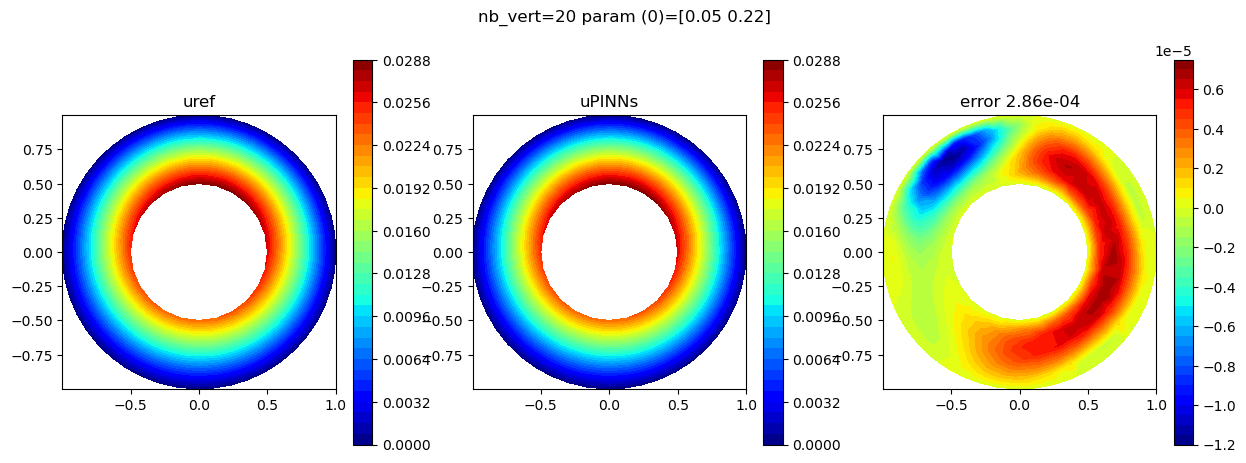

i=0 norme_L2=0.000286103018667398
1 

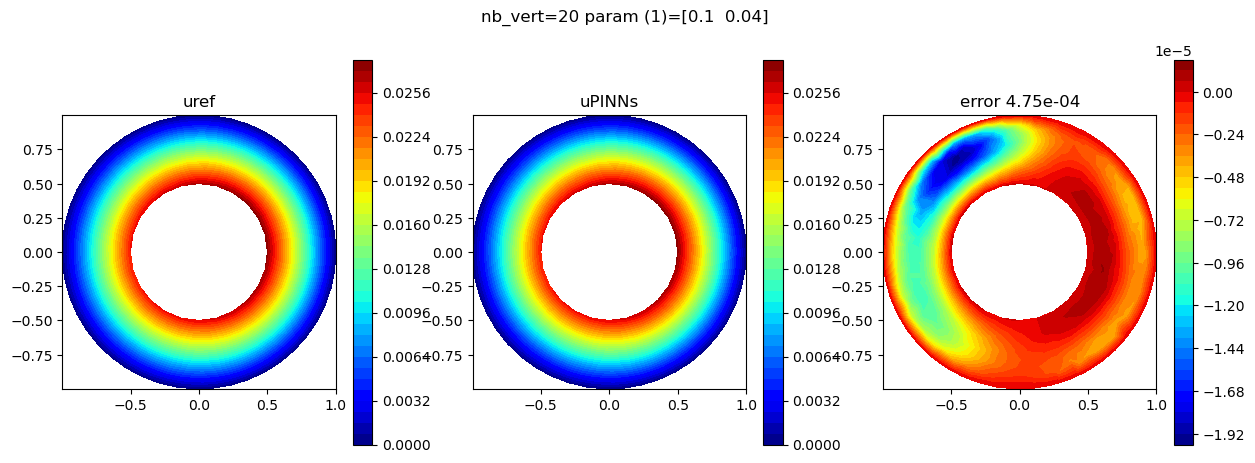

i=1 norme_L2=0.0004748919901925534
2 

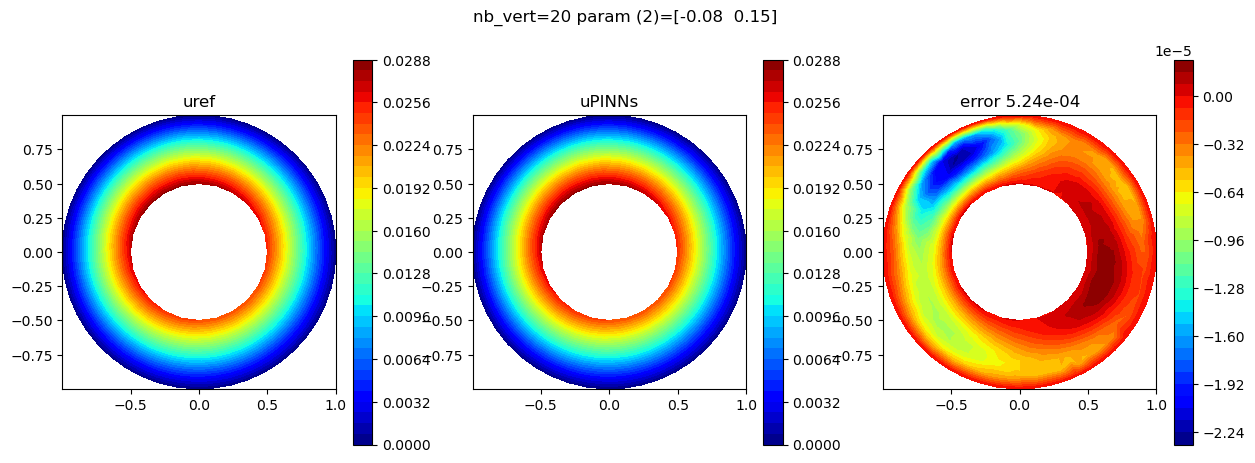

i=2 norme_L2=0.0005241066217422083
3 

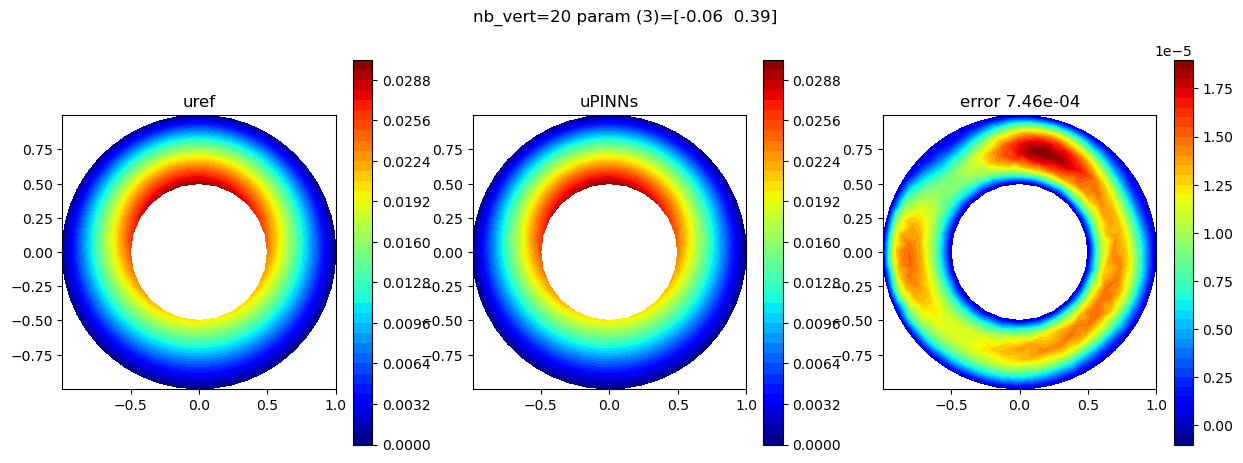

i=3 norme_L2=0.0007459640008656318
4 

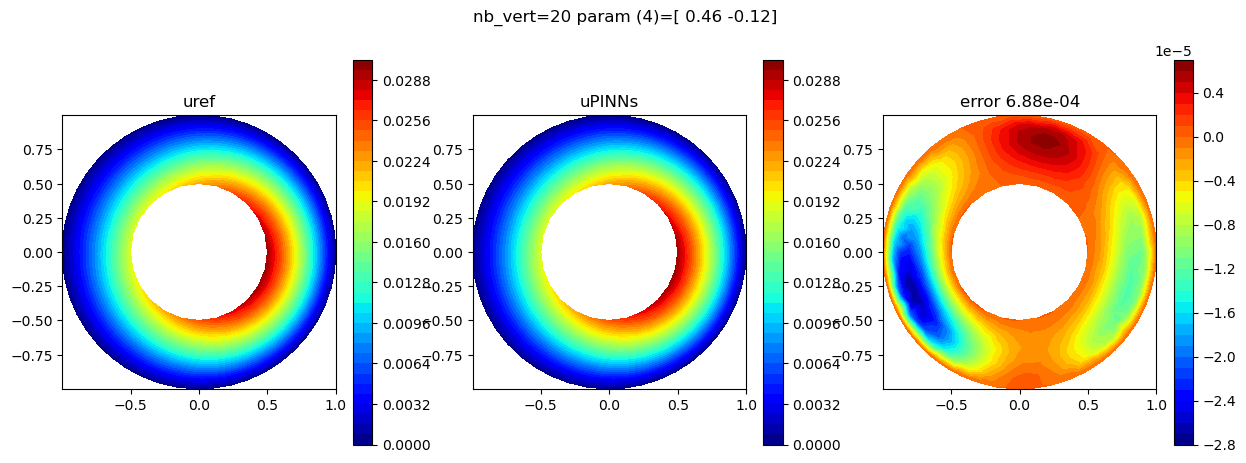

i=4 norme_L2=0.0006882811285986161
5 

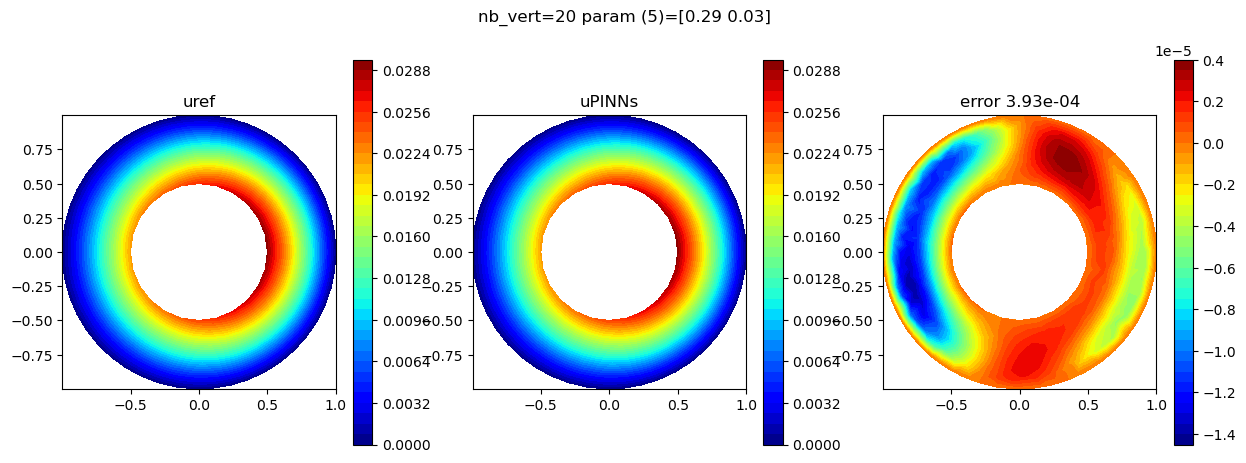

i=5 norme_L2=0.00039291488840213404
6 

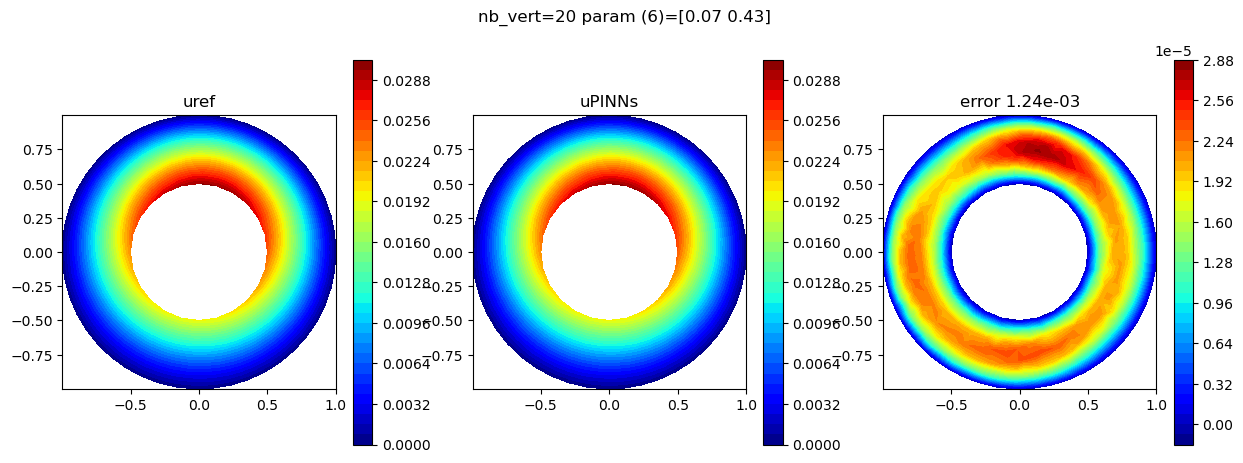

i=6 norme_L2=0.0012433128849176124
7 

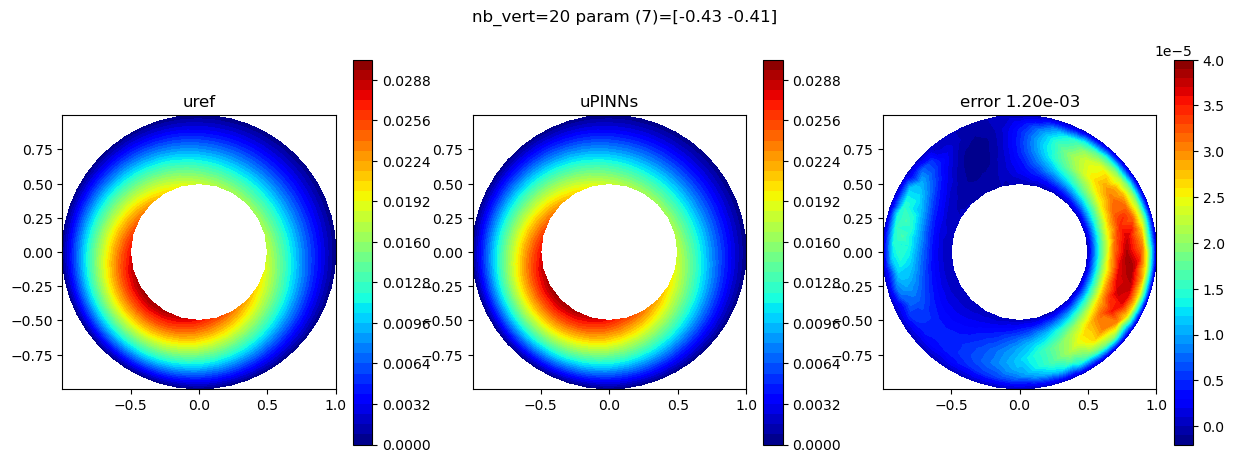

i=7 norme_L2=0.0012006030021477578
8 

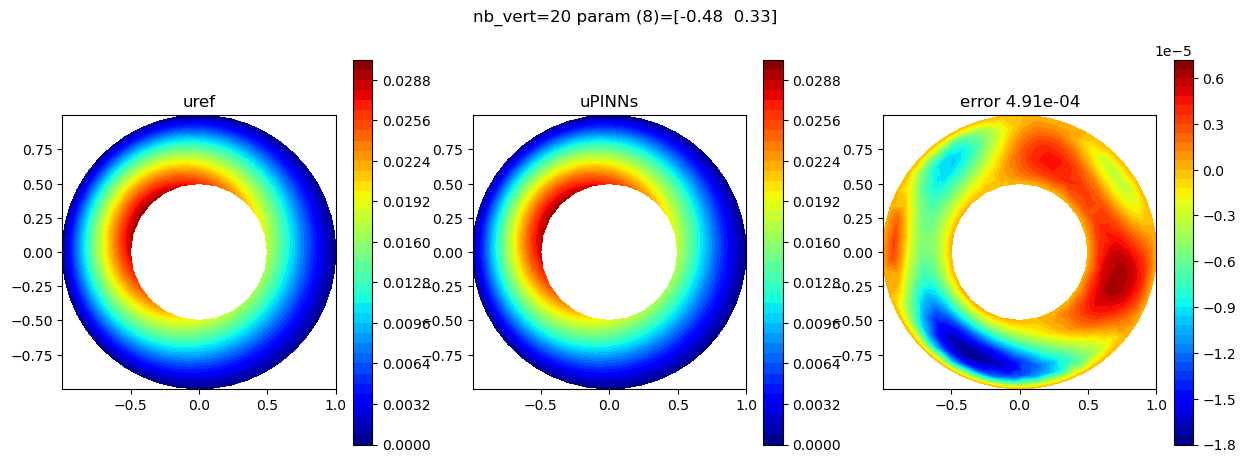

i=8 norme_L2=0.0004912527204849668
9 

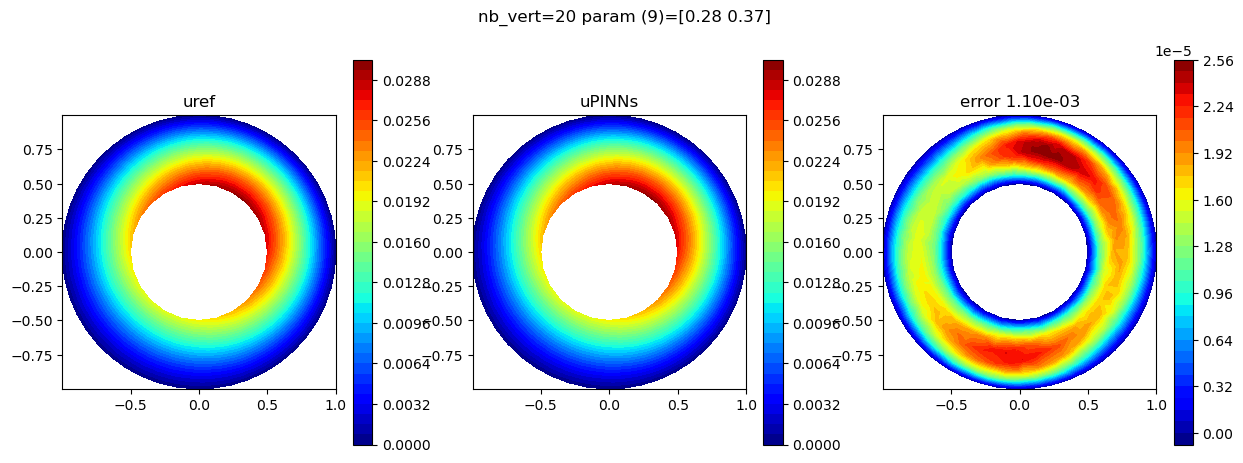

i=9 norme_L2=0.0010966598152928112
10 

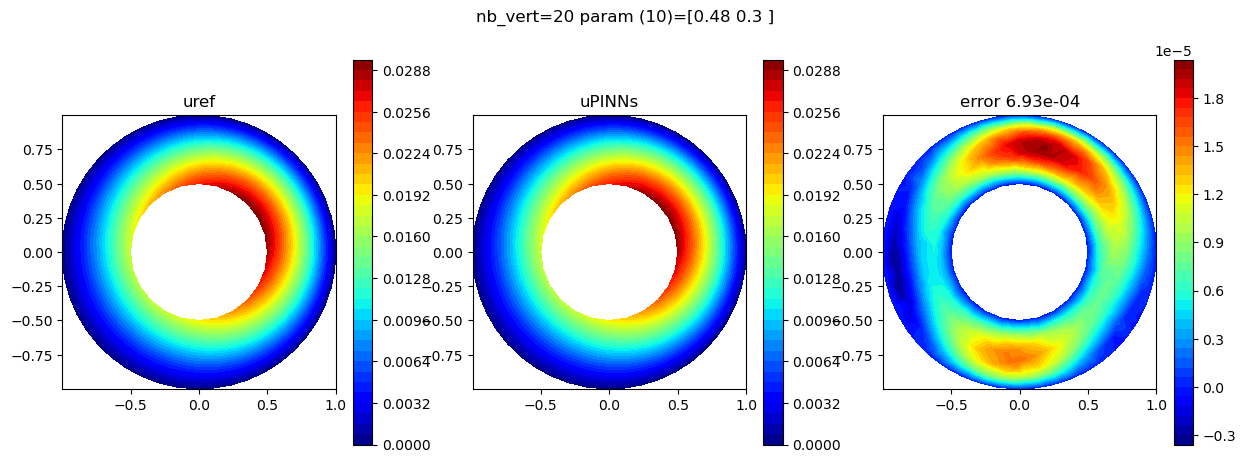

i=10 norme_L2=0.0006925945720868432
11 

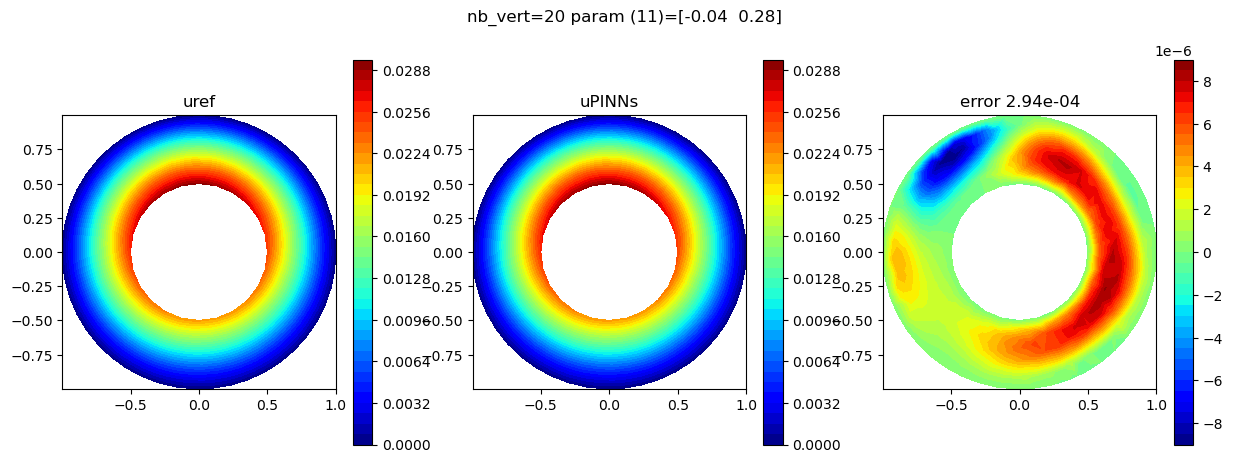

i=11 norme_L2=0.00029449419137685036
12 

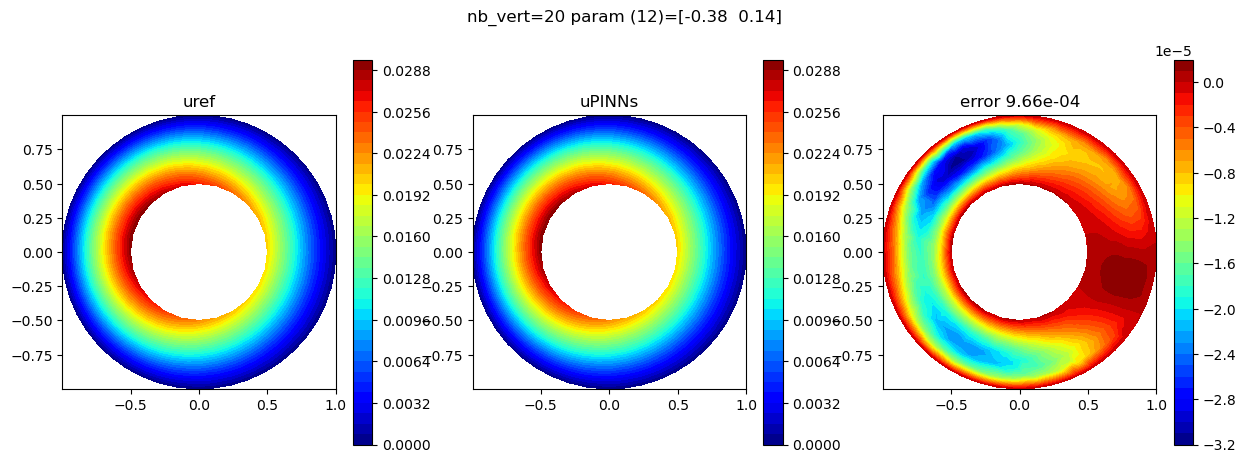

i=12 norme_L2=0.0009661801225201987
13 

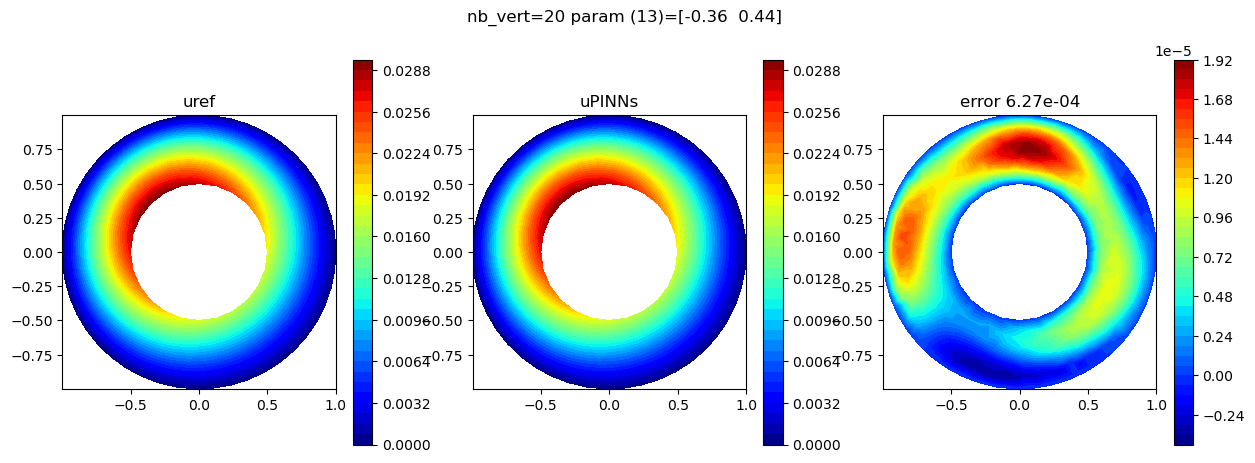

i=13 norme_L2=0.0006267635659473009
14 

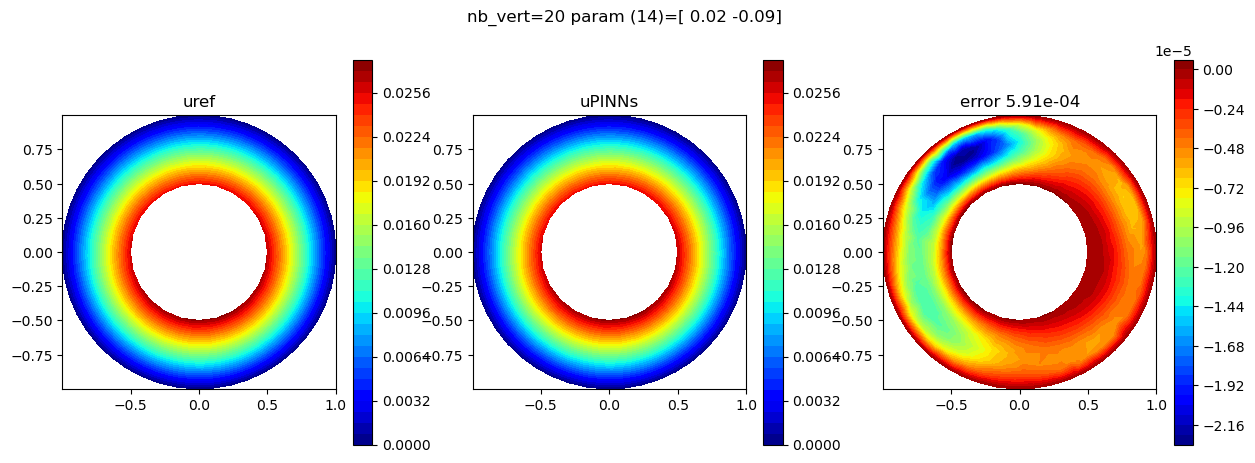

i=14 norme_L2=0.0005908430111532598
15 

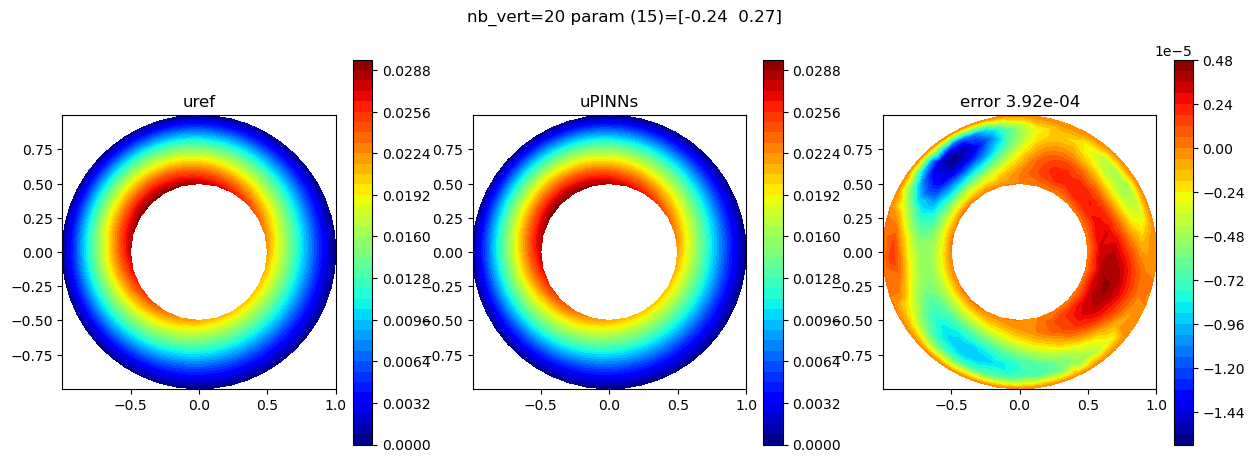

i=15 norme_L2=0.0003916570478171899
16 

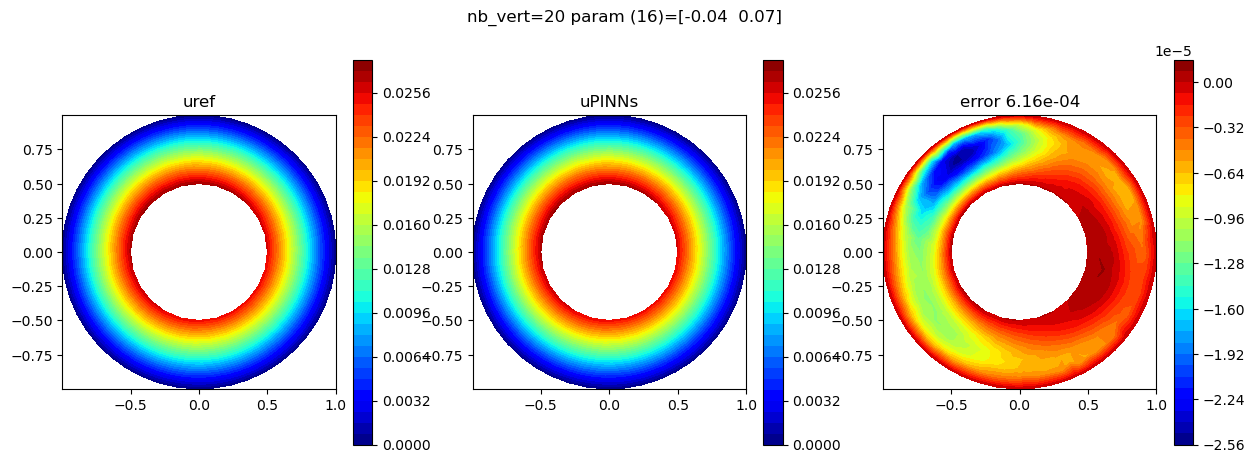

i=16 norme_L2=0.0006159343009792008
17 

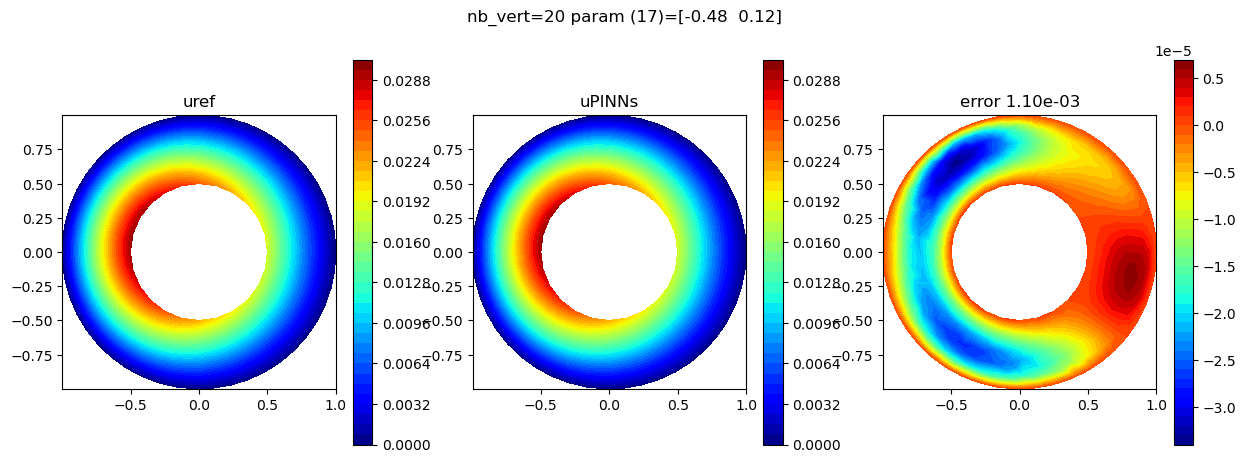

i=17 norme_L2=0.001096740523087203
18 

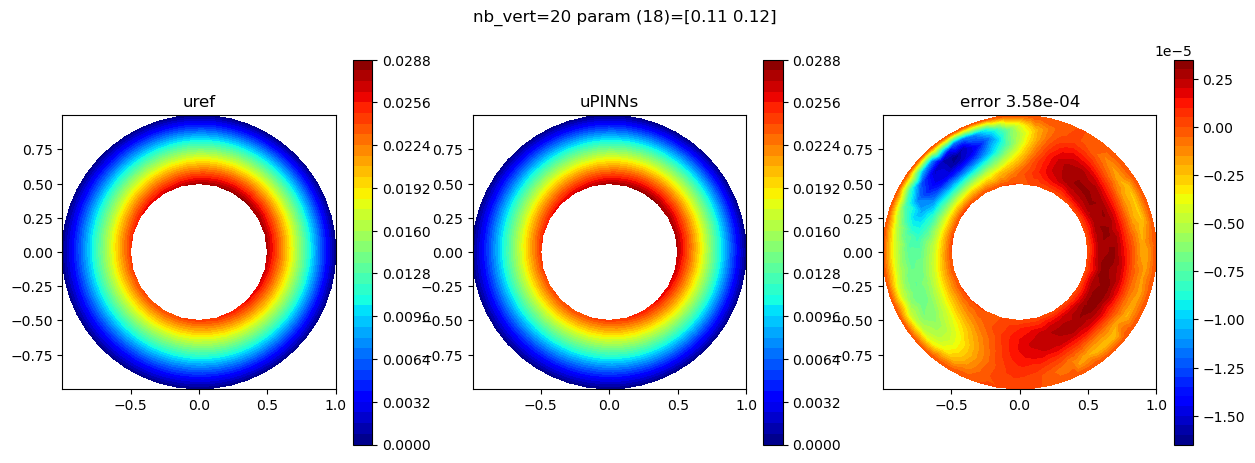

i=18 norme_L2=0.0003579410381016453
19 

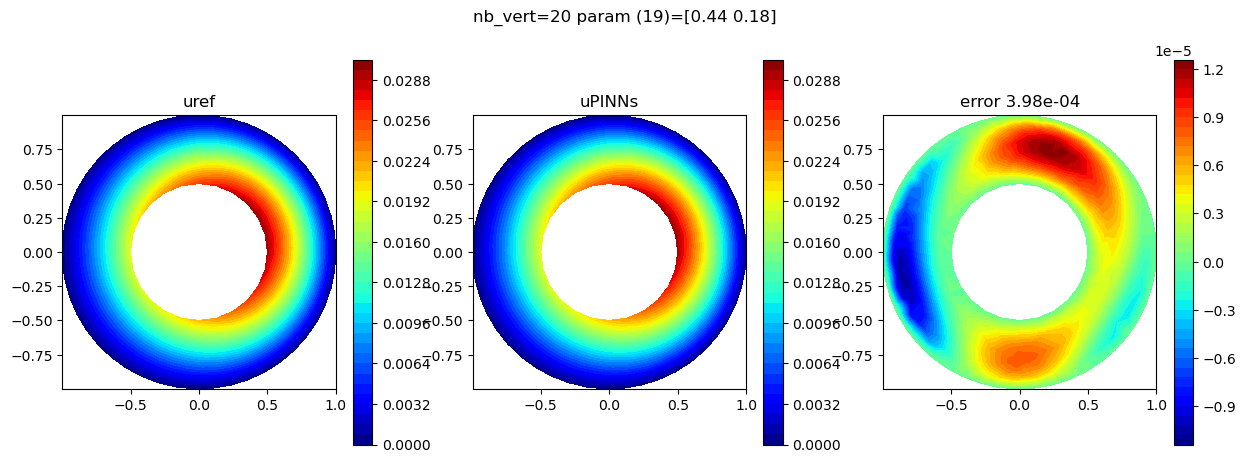

i=19 norme_L2=0.0003978216264130301



In [19]:
df_PINNs, tab_err_PINNs = run_PINNs(degree,new_run=True)

In [20]:
tab_err_PINNs.mean(axis=0)

array([0.00065875])